# Detecting Keyword Spam in Product Descriptions

## Project Objective

The objective of this project is to develop a robust machine learning model to automatically detect keyword spamming in product descriptions on the Depop platform. Keyword spamming refers to the practice where sellers include excessive or unrelated brand names in their listings (e.g., inserting "Levi" in a product description for non-Levi jeans) to manipulate the platform's search rankings.

This behavior undermines the fairness and accuracy of search results, negatively impacting user trust and experience.

By accurately identifying and flagging such spammy descriptions, this model aims to:

1. Improve the relevance and fairness of search results across the platform
2. Enhance the shopping experience for genuine buyers
3. Discourage sellers from engaging in manipulative or misleading practices

This notebook builds upon an initial model prototype created by a junior data scientist. The key goals of this iteration include:

1. Identifying and resolving flaws in the existing modeling logic
2. Designing and implementing more expressive and informative features
3. Improving model accuracy and generalizability
4. Refactoring the codebase for modularity, scalability, and production-readiness

Ultimately, this solution is intended to serve as a foundation for integrating keyword spam detection into Depop's listing moderation pipeline.



## Environment Setup

Environment Details:

Python version: 3.11.9. 

All code tested and validated on this version to ensure compatibility and reproducibility.

In [1]:
! pip install -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


## Importing Libraries and Setting Up NLP Tools

In [2]:
# Import necessary libraries and modules for data processing, NLP, ML, and visualization
import os                  
import re                  
import nltk              
import shap                
import spacy               
import truecase            
import unidecode           
import numpy as np         
import pandas as pd       
import contractions        
import xgboost as xgb      
from itertools import chain 
import matplotlib.pyplot as plt 

# Sklearn modules for ML tasks: feature extraction, model selection, evaluation metrics
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve
)

# Download required models and datasets for NLP tasks
# - SpaCy's English small model for tokenization, POS tagging, lemmatization, and named entity recognition
!python -m spacy download en_core_web_sm

# - NLTK datasets for tokenization and stopwords to remove common words in preprocessing
nltk.download('punkt')
nltk.download('stopwords')

# Configure pandas display options for better readability of dataframes in notebooks or console
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)     
pd.set_option('display.max_colwidth', None)  

# Load SpaCy English model for further NLP processing in the pipeline
nlp = spacy.load("en_core_web_sm")

/Users/ganeshmanepalli/Desktop/Mani/depop/denv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 9.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>


## Data Ingestion

In [3]:
# Get the current working directory path
cwd = os.getcwd()

# Load the training dataset from the 'data' folder using an absolute path
train_data = pd.read_csv(os.path.join(cwd, "data/train_set.tsv"), sep="\t")

# Load the testing dataset from the 'data' folder using an absolute path
test_data = pd.read_csv(os.path.join(cwd, "data/test_set.tsv"), sep="\t")

## Data Understaning

### Train Data

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   1500 non-null   int64 
 1   product_id   1500 non-null   int64 
 2   image_url    1499 non-null   object
 3   description  1500 non-null   object
 4   yes_count    1500 non-null   int64 
 5   no_count     1500 non-null   int64 
 6   label        1500 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 82.2+ KB


In [5]:
print(f"Number of duplicate rows in train_data: {train_data.duplicated().sum()}")

Number of duplicate rows in train_data: 0


In [6]:
train_data.head()

Unnamed: 0  product_id  \
0           0   180202844   
1           1   178987418   
2           2   179026287   
3           3   179777475   
4           4   179251995   

                                                                                  image_url  \
0  https://pictures.depop.com/b0/11081592/800418680_447343598d2a499b9a89db57a163aaed/P0.jpg   
1  https://pictures.depop.com/b0/15550474/796003379_a24d777cfab146a183debdd15b83c217/P0.jpg   
2   https://pictures.depop.com/b0/9626292/796146728_216305d93bd54482a3d6aa6d98f7125c/P0.jpg   
3   https://pictures.depop.com/b0/4624812/798877998_a87392fa3c0849829110ec041ec8911a/P0.jpg   
4  https://pictures.depop.com/b0/16820173/796963662_f1680360e52a4230a905b0ba084a7dbb/P0.jpg   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        description  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               super cute high waisted blue jeans. recommended for shorter / petite girls, i'm 5'1 and it fits me perfect. (example shown in last pic)  these are more of jeggings than jeans and have a polyester material inside.  only flaw: the zipper goes down by itself sometimes   branded for exposure  size 0 / waist 23   
1                                                                                                                                                                    Jordan 5 P51 Camo Size 9 Good condition  Soles have yellowing  No box or lacelocks  $160    Travis Supreme concepts Jordan 1 3 5 6 7 11 12 Nike ovo Kanye yeezy boost 350 shadow royal bred shattered cement top 3 black toe infrared raptor gamma space jam air max vapormax flyknit Travis Scott kaws off white atmos 95 97 98 silver gold bullet protro Kobe fieg kith Levi’s undefeated Palace tinker stash SB dunk stone island Foamposite plus Acronym VF Wotherspoon 270 SW LeBron Kyrie Pippen Metallic Penny Orlando Dunkman Eggplant Chrome All Star Pearl Camo JTH powder olive protro presto off white butter He got game cdg bogo Paris saint Germain Court purple pine green blazer union diamond Dunk cdg staple pigeon Diamond resale bape Zoom fly concord union Purple lobster concepts 997  converse homage   
2  Lovely baby blue Karen Millen scoop neck cardigan💙🤍💙 so cute and elegant xxx  #y2k #90s #00s 2000s fendi #vintage #streetwear festival summer versace moschino nastygal topshop ratandboa brandy Melville sportsbra urbanoutfitters gucci playboy remake louisvuitton dolce&gabbana bikini chanel cami corset chinese oriental bodycon dress top t shirt fluffy o

In [7]:
train_data.tail()

Unnamed: 0  product_id  \
1495        1495   179734287   
1496        1496   180469020   
1497        1497   179187759   
1498        1498   179994428   
1499        1499   179231146   

                                                                                     image_url  \
1495  https://pictures.depop.com/b0/16096527/798722435_d5c8bccc2ff543b78a41206078b7ea00/P0.jpg   
1496  https://pictures.depop.com/b0/19036937/801383972_397e709c52964b67b333c01b7f0cbcac/P0.jpg   
1497  https://pictures.depop.com/b0/21531917/796666446_5d83cb31beae4f00a5741f8347276f43/P0.jpg   
1498  https://pictures.depop.com/b0/13440101/799668261_f26b8ecdae0243b4a640442f0ece8c44/P0.jpg   
1499  https://pictures.depop.com/b0/22729554/796885028_3699f47f10224c9fa298b3b2a083c8fd/P0.jpg   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    description  \
1495                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       BLUE CHAMPION JUMPER size L 8/10 condition  ignore -  #sweater#champion#championjumper#jumper#hoodie   
1496                                                                                                    LuluLemon white and navy blue tee stitching down the back  white in the front and blue in the back size 6 but can fit a size 4  🐝DM BEFORE PURCHASE🐝  Brandy Melville vintage 90s 80s 2000s urban outfitters hysteric glamour juicy flea market thrifted Los Angeles Levi's shirts crop top unif disco Kendall Jenner Devon lee Carlson long cropped crewneck skirt butterfly shorts jeans flowery floral silk leopard animal print tie dye Bella hadid Billie eilish cute edgy leather wrangler tank top lingerie bralette kawaii beautiful nyc ed hardy von dutch rainbow white track suit velour dior Chanel Victoria's Secret LA dolls kill rings necklaces lulu lemons jewelry gold silver Jordan's Nike dunks Air Force doc martens Jordan 1 golf wang pure money princess polly vans black white pink purple roses daisies rose daisy ruffle pattern floral sheer pastel silence and noise creme   
1497                                                                                                                                                                                                                                                                                           

The training dataset contains 1500 records and 7 features. There are no duplicate rows. Among the features, image_url and description are string-type, while the remaining features are numeric. The image_url column has one missing value.

### Test Data

In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   500 non-null    int64 
 1   product_id   500 non-null    int64 
 2   image_url    500 non-null    object
 3   description  500 non-null    object
 4   yes_count    500 non-null    int64 
 5   no_count     500 non-null    int64 
 6   label        500 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 27.5+ KB


In [9]:
print(f"Number of duplicate rows in test_data: {test_data.duplicated().sum()}")

Number of duplicate rows in test_data: 0


In [10]:
test_data.head()

Unnamed: 0  product_id  \
0           0   179149852   
1           1   179090413   
2           2   178975684   
3           3   180466398   
4           4   180217128   

                                                                                  image_url  \
0  https://pictures.depop.com/b0/11939830/796589383_5126bf70c4894f95a64ff7257b0cfee5/P0.jpg   
1  https://pictures.depop.com/b0/19685060/796378118_f9964b44b84944638dcfa17d36500597/P0.jpg   
2  https://pictures.depop.com/b0/12834409/795862740_4521c058af0849b0923c6f3576dae834/P0.jpg   
3  https://pictures.depop.com/b0/12527213/801375208_e19263e9fac5495f846bbf9c935102cc/P0.jpg   
4  https://pictures.depop.com/b0/19526408/800471075_aad6c90ac9f1484f8e81959e08123b0c/P0.jpg   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         description  \
0                         gorgeous y2k juicy couture velvet zip up. super pretty turquoise color. worn only a few times and in perfect condition. 100% authentic! size medium but would fit a small nicely  tags #lingerie #lace #vintagedepop #sofuckingdepop #depopfamous lily rose depp devon lee carlson corset black tank cami 90s 2000s y2k tank top camisole black lace top mock lingerie black v neck lace lined top strappy top carrie bradshaw milkmaid cami crop top blouse v neck lace sex and the city cruel intentions clueless black swan victorias secret cami 60s 70s 80s 90s brandy melville urban outfitters thrift aesthetic unif babydoll cheetah lace silk satin retro babygirl sheer jewelry egirl soft girl trendy angel baby princess polly juicy couture paris hilton pink   
1  Men's Adidas classic Joggers / Tracksuit Bottoms   Condition - 9/10 slight bobbles in places but overall still amazing condition, condition reflected in price however.  Size -large (old 40/42 tag however this is not reflective of measurements) Colour - Black with white and blue detailing    ••••••••••••••••••••••••••  FAST AND FREE UK POSTAGE 📮 ADD UK FIRST CLASS POSTAGE FOR £5 NO RETURNS OR REFUNDS ❌ WORLD WIDE SHIPPING - MESSAGE US!🌍 DISCOUNT ON BUNDLE DEALS 💰 HAPPY TO HAGGLE ON PRICES 🤼‍♂️  Tags: burberry y2k Nike Adidas brandy melville fashion vintage designer streetwear sale sustainable oh polly bo & tee supreme Versace stone island Tommy Hilfiger Ralph Lauren sweatshirt jumper dickies fleece Lacoste USA Baseball College University NFL Starter  #saletime   
2                                       This medium wash denim jacket with bronze metal details is the perfect basic denim jacket that every girl needs. This jacket is super durable but lightweight. It looks good with everything.  This is marked an XL but would best fit an XS-M for more of an oversized look. The model is a S. The brand is Blue Age Jeans USA. There are no flaws as far as I can tell.   ~ignore tags~  brandy melville urban outfitters pacsun aesthetic 70s 80s 90s y2k 00s shirt jacket retro levis 550s 501s ribcage floral dress vintage thrift corduroy nike vans depop shorts top bottoms pants jeans skirt earrings necklace ring bracelet shoes sandals punk edgy grunge egirl soft softgirl skater hippie #denimjacket #jacket #denim #vintage #americanvintage   
3                                                                                                                                                        

In [11]:
test_data.tail()

Unnamed: 0  product_id  \
495         495   179256053   
496         496   178771251   
497         497   179539597   
498         498   178805670   
499         499   180184482   

                                                                                    image_url  \
495  https://pictures.depop.com/b0/17332812/796978580_48a6220d0e8d46118b42c9dd80b1f508/P0.jpg   
496   https://pictures.depop.com/b0/8188507/795209732_5bf96bb9247140dda6cb529a06fbaeb3/P0.jpg   
497   https://pictures.depop.com/b0/7850027/798012712_d4d51fda9eb74ff78f266ed6d5901583/P0.jpg   
498  https://pictures.depop.com/b0/15882245/795332019_95f56e31f0b34045a537ccc3ddb67719/P0.jpg   
499   https://pictures.depop.com/b0/5064931/800352381_3cedcf9e8a424959bb87edd3fae364d7/P0.jpg   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           description  \
495                                                                                                                                                                                                                                                                     Rare Vintage purple sweater in great condition 9/10 size Small   .    .  .     Tags - 90s / 2000 / distressed / faded / state / high fashion / 80s / tech / diy   / band / tour / vintage / single stitch / long sleeve / tee shirt / crew neck / hoodie / sweater  / oversized / baggy / fire / custom  / cat / black / white / music / cars / urban / yellow / streetwear / red / blue  / date / y2k  / retro / skull  / stripped / magazine / art  / thrift / goodwill / vtg / appeal / graphic tee / hype / punk / denim / jeans / pants /   
496                                                                                                                                                                                                                                                                                                                                                                                                                                    Cosy cropped vintage fleece in pastel shades tie dye print. Featuring turtle neck, cosy slouchy shape and toggles to pull in the elasticated hem. A cosy fleece is a wardrobe staple! 🌸🌸 Will fit sizes 6 8 10 12 comfortably. Model is size 10/12 and 5'5 for ref 🌸🌸  Happy to ship world wide dm for pricing 🌎  # Aztec crazy geometric rainbow patterned art pullover jumper   
497  “ THE ELLA CAMI ”  🌸🌸🌸🌸  - softest quality red and black cheetah print cami with a bow  - true to size  - FIRST CLASS SPEEDY USPS SHIPPING✨🌈  - ⭐️ 10% OFF ALL BUNDLES ⭐️  ___________________________  🏷 ‘s:  vintage jean shorts lace cami y2k 2000s  vintage #lacecami #vintage  feminine #cherry u neck v neck brandy unif tank girly #madisonbeer purple #morgandetoi leopard cheetah animal print pinterest trendy cute girly cropped y2k 2000s trendy bright cross lace cami y2k cami y2k top y2k tank deadstock cami trendy cami trendy tank top babydoll slipdress babydoll top babydoll dress model off duty kendall jenner madison beer instagram outfit instagram top 2000s top 90s top 90s cami 80s 70s 00s 000s light brown lace cami cami y2k dusty rose cami y2k cami top y2k top cross lace cami   
498                                                        

The testing dataset contains 500 records and 7 features. There are no duplicate rows. Among the features, image_url and description are string-type, while the remaining features are numeric.

## Exploratory Data Analysis

### Univariate Analysis

#### Unnamed: 0

In [12]:
train_data["Unnamed: 0"].nunique()

1500

The feature Unnamed: 0 represents the index number and does not contribute meaningfully to analysis or model building. Therefore, it can be safely dropped.

#### product_id

In [13]:
train_data["product_id"].nunique()

1500

The feature product_id is a unique identifier (primary key) for each product. Since it does not provide predictive value, it can be excluded from analysis and model building.

#### image_url

In [14]:
train_data["image_url"].nunique()

1499

The feature image_url contains the product images paths, uploaded by the user. Currently, this feature is not utilized in model building. However, future improvements could involve extracting descriptions from these images using large language models (LLMs) or similar techniques, which could then be incorporated as input features for the model.

#### description

In [15]:
train_data["description"]

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            super cute high waisted blue jeans. recommended for shorter / petite girls, i'm 5'1 and it fits me perfect. (example shown in last pic)  these are more of jeggings than jeans and have a polyester material inside.  only flaw: the zipper goes down by itself sometimes   branded for exposure  size 0 / 

The description feature contains detailed information about the product provided by the user. This feature is crucial and will play a key role in the model building process.

#### yes_count

In [16]:
train_data["yes_count"].value_counts()

yes_count
3    824
0    557
2     47
1     38
4     26
6      6
5      2
Name: count, dtype: int64

The feature yes_count currently lacks a data description, so its meaning is unclear. As an improvement, a clear description of this feature should be added to ensure better understanding and effective use in the analysis or model building.

#### no_count

In [17]:
train_data["no_count"].value_counts()

no_count
0    845
3    555
1     49
2     33
4     17
5      1
Name: count, dtype: int64

The feature no_count also lacks a data description, similar to yes_count. To improve clarity and usability, detailed descriptions should be added for both features.

#### label

In [18]:
train_data["label"].value_counts()

label
1    897
0    603
Name: count, dtype: int64

The target variable is the label feature, which exhibits a moderate class imbalance with an approximate ratio of 3:2 between the classes. While addressing this imbalance is not strictly required, implementing techniques to handle it could improve model robustness and predictive reliability.

### Bivariate Analyis

In [19]:
train_data[["yes_count","label"]].corr()

yes_count     label
yes_count   1.000000  0.969244
label       0.969244  1.000000

In [20]:
train_data[["yes_count","label"]].value_counts()

yes_count  label
3          1        823
0          0        557
2          1         40
1          0         38
4          1         26
2          0          7
6          1          6
5          1          2
3          0          1
Name: count, dtype: int64

In [21]:
train_data[["no_count","label"]].corr()

no_count     label
no_count  1.000000 -0.982825
label    -0.982825  1.000000

In [22]:
train_data[["no_count","label"]].value_counts()

no_count  label
0         1        845
3         0        555
1         1         49
2         0         30
4         0         17
2         1          3
5         0          1
Name: count, dtype: int64

In [23]:
train_data[["no_count","label","yes_count"]].corr()

no_count     label  yes_count
no_count   1.000000 -0.982825  -0.971350
label     -0.982825  1.000000   0.969244
yes_count -0.971350  0.969244   1.000000

From the bivariate analysis, the features no_count, yes_count, and label exhibit high correlation. Due to the lack of detailed data descriptions, these features have been excluded from further analysis.

From the univariate analysis, it is clear that the description feature plays a vital role in predicting the target variable. Now, let’s explore the description in more detail.

In [24]:
for index in range(0, len(train_data)):
    print(f"{index} -> {train_data['description'].iloc[index]}")

0 -> super cute high waisted blue jeans. recommended for shorter / petite girls, i'm 5'1 and it fits me perfect. (example shown in last pic)  these are more of jeggings than jeans and have a polyester material inside.  only flaw: the zipper goes down by itself sometimes   branded for exposure  size 0 / waist 23
1 -> Jordan 5 P51 Camo Size 9 Good condition  Soles have yellowing  No box or lacelocks  $160    Travis Supreme concepts Jordan 1 3 5 6 7 11 12 Nike ovo Kanye yeezy boost 350 shadow royal bred shattered cement top 3 black toe infrared raptor gamma space jam air max vapormax flyknit Travis Scott kaws off white atmos 95 97 98 silver gold bullet protro Kobe fieg kith Levi’s undefeated Palace tinker stash SB dunk stone island Foamposite plus Acronym VF Wotherspoon 270 SW LeBron Kyrie Pippen Metallic Penny Orlando Dunkman Eggplant Chrome All Star Pearl Camo JTH powder olive protro presto off white butter He got game cdg bogo Paris saint Germain Court purple pine green blazer union di

## Data Preprocessing

### Feature Engineering

In [25]:
def hashtag_density(text):
    """
    Calculates the density of hashtags in a given text.
    
    Hashtag density is defined as the proportion of tokens starting with '#' 
    relative to the total number of tokens. A high hashtag density may indicate 
    attempts to game search results by keyword stuffing.

    Args:
        text (str): Input text.

    Returns:
        float: Ratio of hashtags to total tokens.
    """
    tokens = text.split()
    hashtags = [t for t in tokens if t.startswith("#")]
    return len(hashtags) / len(tokens) if tokens else 0.0


def unique_token_ratio(text):
    """
    Calculates the ratio of unique tokens to total tokens in the text.

    This feature provides a measure of lexical diversity. Lower values might suggest 
    repetition or redundancy, which can be indicative of spammy content.

    Args:
        text (str): Input text.

    Returns:
        float: Unique tokens / total tokens.
    """
    tokens = text.split()
    unique_tokens = set(tokens)
    return len(unique_tokens) / len(tokens) if tokens else 0.0


def noun_ratio(text):
    """
    Calculates the proportion of nouns in the text using SpaCy POS tags.

    Spammy text may exhibit unusual noun-to-word distributions. This ratio gives 
    insight into the grammatical content of the text.

    Args:
        text (str): Input text.

    Returns:
        float: Ratio of NOUN tokens to total tokens.
    """
    doc = nlp(text)
    noun_count = sum(1 for token in doc if token.pos_ == "NOUN")
    total_tokens = len(doc)
    return noun_count / total_tokens if total_tokens else 0.0


def capitalization_rate(text):
    """
    Calculates the proportion of uppercase letters to total alphabetic characters.

    Excessive capitalization is often used in spam or attention-grabbing text. 
    This metric can help identify such patterns.

    Args:
        text (str): Input text.

    Returns:
        float: Uppercase characters / total alphabetic characters.
    """
    letters = [c for c in text if c.isalpha()]
    uppercase_letters = sum(1 for c in letters if c.isupper())
    return uppercase_letters / len(letters) if letters else 0.0


def proportion_of_stopwords(description):
    """
    Calculates the proportion of stopwords in a given text description.

    Stopwords are common function words (e.g., 'and', 'the', 'is'). A very low 
    proportion might indicate unnatural or keyword-heavy content.

    Args:
        description (str): The input text description.

    Returns:
        float: Ratio of stopwords to total tokens.
    """
    tokens = description.split()
    num_stopwords = len([word for word in tokens if word.lower() in nlp.Defaults.stop_words])
    return num_stopwords / len(tokens) if len(tokens) else 0.0


def average_length_of_word(description):
    """
    Computes the average length of words in the text.

    Longer words may suggest technical or sophisticated language, whereas shorter 
    average length could indicate informal or repetitive use.

    Args:
        description (str): The input text description.

    Returns:
        float: Mean character length per word.
    """
    tokens = description.split()
    return np.mean([len(word) for word in tokens]) if len(tokens) else 0.0


def proportion_of_numbers(description):
    """
    Calculates the proportion of purely numeric tokens in the text.

    High proportion of numbers may indicate structured spam or product codes.
    Useful in distinguishing informative vs spammy listings.

    Args:
        description (str): The input text description.

    Returns:
        float: Ratio of numeric tokens to total tokens.
    """
    tokens = description.split()
    num_digits = len([word for word in tokens if word.isdigit()])
    return num_digits / len(tokens) if len(tokens) else 0.0


### Text Preprocessing

In [26]:
def normalise_nonascii_chars(input_str):
    """
    Converts non-ASCII characters to their closest ASCII equivalent using the Unidecode library.
    
    Example: 'café' → 'cafe'
    
    Args:
        input_str (str): The original string containing non-ASCII characters.
    
    Returns:
        str: Normalized string with only ASCII characters.
    """
    return unidecode.unidecode(input_str)


def replace_special_chars(main_string):
    """
    Replaces common special characters (punctuation, symbols, etc.) with a space.
    
    This helps in separating tokens more cleanly and avoids noise in downstream text processing.

    Args:
        main_string (str): The input text string.
    
    Returns:
        str: String with special characters replaced by space.
    """
    return re.sub(r"[,;@#!\?\+\*\n\-: /]", " ", main_string)


def keep_alphanumeric_chars(string_input):
    """
    Removes all characters except letters, digits, spaces, and the ampersand (&).
    
    Useful for removing unwanted punctuation or symbols that might interfere with tokenization.

    Args:
        string_input (str): The cleaned text string.
    
    Returns:
        str: String with only alphanumeric characters and spaces.
    """
    return re.sub(r"[^A-Za-z0-9& ]", "", string_input)


def remove_spaces(string_input):
    """
    Removes extra whitespace by joining the string back together with single spaces.

    Ensures consistent spacing between words and removes any leading/trailing or multiple spaces.

    Args:
        string_input (str): The text with potential extra spaces.
    
    Returns:
        str: Cleaned string with normalized whitespace.
    """
    return " ".join(string_input.split())


def fix_contractions(string_input):
    """
    Expands English language contractions into their full forms using the contractions library.

    Example: "don't" → "do not", "I'm" → "I am"

    Args:
        string_input (str): The input string containing contractions.
    
    Returns:
        str: String with contractions expanded.
    """
    return contractions.fix(string_input)


def lemmatize(string_input):
    """
    Applies lemmatization to reduce words to their base or dictionary form using spaCy.

    Example: "running", "ran" → "run"

    Args:
        string_input (str): The input string for lemmatization.
    
    Returns:
        str: Lemmatized version of the string.
    """
    token_object = nlp(string_input)
    lemmas_list = [
        word.lemma_ if word.lemma_ != "-PRON-" else word.text for word in token_object
    ]
    return " ".join(lemmas_list)


def drop_digits(s):
    """
    Removes all numeric digits from the input string.

    Useful when numbers are irrelevant or noisy in the context of the task.

    Args:
        s (str): The input string possibly containing digits.
    
    Returns:
        str: String with digits removed.
    """
    return "".join([i for i in s if not i.isdigit()])


def clean_description(input_str):
    """
    Master text cleaning function to prepare raw text data for modeling.

    Applies a series of preprocessing steps including:
        - Normalizing non-ASCII characters
        - Expanding contractions
        - Lowercasing
        - Replacing and removing special characters
        - Keeping only alphanumeric characters
        - Lemmatizing
        - Removing extra spaces

    Args:
        input_str (str): Raw text description.

    Returns:
        str: Fully cleaned and normalized string ready for feature extraction or modeling.
    """
    input_str = normalise_nonascii_chars(input_str)   
    input_str = fix_contractions(input_str)           
    input_str = input_str.lower()                     
    input_str = replace_special_chars(input_str)      
    input_str = keep_alphanumeric_chars(input_str)    
    input_str = lemmatize(input_str)                  
    input_str = remove_spaces(input_str)    
    # input_str = drop_digits(input_str)              
    return input_str

In [27]:
def preprocess_and_add_features(df):
    """
    Preprocess and engineer text features from the 'description' column.

    This function performs a combination of text cleaning and handcrafted feature extraction
    to enrich the dataset for machine learning tasks such as classification.

    It performs the following steps:

    1. Raw Feature Extraction (on original text):
        - `hashtag_density`: Proportion of tokens starting with '#'.
        - `capitalization_rate`: Proportion of capital letters to total alphabetic characters.

    2. Text Cleaning:
        - Applies `clean_description()` function which typically includes:
            * Lowercasing
            * Removal of punctuation and special characters
            * Lemmatization
            * Normalization (e.g., whitespace fixing)

    3. Feature Extraction on Cleaned Text:
        - `proportion_of_stopwords`: Measures how much of the text consists of common stopwords.
        - `average_length_of_word`: Average number of characters per word.
        - `proportion_of_numbers`: Ratio of numeric tokens to total tokens.
        - `unique_token_ratio`: Uniqueness of vocabulary in the text.
        - `noun_ratio`: Ratio of noun words to total words (based on SpaCy POS tagging).

    4. Final Cleanup:
        - Applies `drop_digits()` to remove any remaining digit tokens from the cleaned text.

    New Features Added:
        - 'hashtag_density'
        - 'capitalization_rate'
        - 'proportion_of_stopwords'
        - 'average_length_of_word'
        - 'proportion_of_numbers'
        - 'unique_token_ratio'
        - 'noun_ratio'

    Args:
        df (pd.DataFrame): A pandas DataFrame with a column named 'description'.

    Returns:
        pd.DataFrame: A modified DataFrame containing new features and cleaned text.
    """

    df["hashtag_density"] = df["description"].apply(hashtag_density)
    df["capitalization_rate"] = df["description"].apply(capitalization_rate)
    df["description"] = df["description"].apply(clean_description)
    df["proportion_of_stopwords"] = df["description"].apply(proportion_of_stopwords)
    df["average_length_of_word"] = df["description"].apply(average_length_of_word)
    df["proportion_of_numbers"] = df["description"].apply(proportion_of_numbers)
    df["unique_token_ratio"] = df["description"].apply(unique_token_ratio)
    df["noun_ratio"] = df["description"].apply(noun_ratio)
    df["description"] = df["description"].apply(drop_digits)

    return df


The steps are executed in a specific order for logical and technical reasons:

Step 1: Feature Extraction (on Raw Text)
- hashtag_density and capitalization_rate are computed before any text cleaning.

- This is because cleaning would remove or alter hashtags and capital letters, which are essential signals for these features (e.g., excessive hashtags or capital words may indicate spam or promotional content).

Step 2: Text Cleaning
- The description column is cleaned using clean_description() — typically involving lowercasing, punctuation removal, normalization, and lemmatization.

Step 3: Feature Extraction (on Cleaned Text)
- Features like proportion_of_stopwords, average_length_of_word, proportion_of_numbers, unique_token_ratio, and noun_ratio are computed after cleaning, as these metrics are more accurate on normalized text.

- For example, counting stopwords or nouns is more meaningful once the text is free of noise and standard token forms are used.

Step 4: Final Cleaning (drop_digits)
- The drop_digits() function is applied at the end to remove digit tokens from the cleaned description.

- This is done after extracting proportion_of_numbers, so the numeric signal is captured before the digits are stripped from the text.

In [28]:
train_data = preprocess_and_add_features(train_data)
test_data = preprocess_and_add_features(test_data)

### Feature Encoding

### Extraction of Brand Names and Spam-Prone Nouns

In [29]:
def process_named_entities(df):
    """
    Processes named entities from the 'description' column of a DataFrame.

    Steps:
        1. Applies truecasing to standardize capitalization (e.g., "london" → "London").
        2. Applies spaCy NLP pipeline to extract linguistic features.
        3. Extracts named entities using spaCy's NER and saves them as space-separated strings.

    Adds the following columns:
        - 'description_truecase': truecased version of the original description.
        - 'description_nlp': spaCy-parsed Doc objects.
        - 'named_entities': space-separated named entities extracted from each description.

    Args:
        df (pd.DataFrame): DataFrame with a 'description' column.

    Returns:
        pd.DataFrame: Updated DataFrame with named entity features.
    """
    df["description_truecase"] = df["description"].apply(truecase.get_true_case)
    df["description_nlp"] = df["description_truecase"].apply(nlp)
    df["named_entities"] = ""
    for i, doc in df["description_nlp"].items():
        named_entities = set(ent.text for ent in doc.ents)  # Unique named entities
        df.at[i, "named_entities"] = " ".join(named_entities)
    
    return df

In [30]:
train_data = process_named_entities(train_data)
test_data = process_named_entities(test_data)

#### TF-IDF Vectorization for Top 25 Named Entities

In [31]:
# Initialize the TF-IDF Vectorizer using spaCy's stop words
vectorizer_named_entities = TfidfVectorizer(
    stop_words=list(nlp.Defaults.stop_words), 
    max_features=25  # Limit to top 25 features
)

# ---- TRAIN SET ----
# Vectorize 'named_entities' column in training data
df_tfidf_named_entities_train = pd.DataFrame(
    vectorizer_named_entities.fit_transform(train_data["named_entities"]).todense(),
    columns=vectorizer_named_entities.get_feature_names_out()
)

# Rename columns to indicate they're from named entity TF-IDF
df_tfidf_named_entities_train.columns = [
    f"{col}_named_entities" for col in df_tfidf_named_entities_train.columns
]

# Concatenate TF-IDF features with the original training set
train_data = pd.concat([train_data.reset_index(drop=True), df_tfidf_named_entities_train], axis=1)


# ---- TEST SET ----
# Apply the same vectorizer to the test set
df_tfidf_named_entities_test = pd.DataFrame(
    vectorizer_named_entities.transform(test_data["named_entities"]).todense(),
    columns=vectorizer_named_entities.get_feature_names_out()
)

# Rename columns similarly
df_tfidf_named_entities_test.columns = [
    f"{col}_named_entities" for col in df_tfidf_named_entities_test.columns
]

# Concatenate with the original test set
test_data = pd.concat([test_data.reset_index(drop=True), df_tfidf_named_entities_test], axis=1)


/Users/ganeshmanepalli/Desktop/Mani/depop/denv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


TF-IDF Vectorization: Why Top 25 Entities?
In the original pipeline, TF-IDF was applied to extract the top 500 features, but this was reduced to 25 for the following reasons:

- Small Dataset: The training data contains only ~1500 records. Using too many TF-IDF features with limited data increases the risk of overfitting.

- Model Generalization: A smaller, more informative feature set helps the model focus on high-signal words and improves generalization to unseen data.

- Dimensionality vs. Sample Size: Selecting just the top 25 most frequent and relevant terms strikes a better balance between feature richness and model stability.

This change improves performance and ensures the model is more robust and interpretable.

#### TF-IDF Vectorization for Top 25 Description Terms

In [32]:
# # Initialize TF-IDF Vectorizer for 'named_entities' column
# vectorizer_named_entities = TfidfVectorizer(
#     stop_words=list(nlp.Defaults.stop_words),  # Use spaCy's stop words
#     max_features=500  # Limit to 500 most important terms
# )

# # ====== TRAIN DATA PROCESSING ======
# # Apply TF-IDF transformation on training data's 'named_entities' column
# df_tfidf_named_entities_train = pd.DataFrame(
#     vectorizer_named_entities.fit_transform(train_data["named_entities"]).todense(),
#     columns=vectorizer_named_entities.get_feature_names_out()
# )

# # Rename columns for clarity
# df_tfidf_named_entities_train.columns = [
#     f"{col}_named_entities" for col in df_tfidf_named_entities_train.columns
# ]

# # Append TF-IDF features to the original training dataset
# train_data = pd.concat(
#     [train_data.reset_index(drop=True), df_tfidf_named_entities_train],
#     axis=1
# )

# # ====== TEST DATA PROCESSING ======
# # Transform 'named_entities' in test data using the same vectorizer
# df_tfidf_named_entities_test = pd.DataFrame(
#     vectorizer_named_entities.transform(test_data["named_entities"]).todense(),
#     columns=vectorizer_named_entities.get_feature_names_out()
# )

# # Rename test columns similarly
# df_tfidf_named_entities_test.columns = [
#     f"{col}_named_entities" for col in df_tfidf_named_entities_test.columns
# ]

# # Append TF-IDF features to the original test dataset
# test_data = pd.concat(
#     [test_data.reset_index(drop=True), df_tfidf_named_entities_test],
#     axis=1
# )


In this implementation, I chose not to apply TF-IDF vectorization on the description column. The reasons are:

- Curse of Dimensionality: Adding TF-IDF features from free-text fields like description dramatically increases the number of dimensions. Given the dataset size (~1500 records), this would likely lead to overfitting and degraded generalization.

- Alternative Features Used: Instead of raw TF-IDF, more interpretable and compact features (e.g., noun_ratio, hashtag_density, capitalization_rate, etc.) were engineered from the same column to retain meaningful signal in a lower-dimensional space.

Thus, skipping TF-IDF on description helped keep the model simpler, more interpretable, and better aligned with the size of the training data.

### Drop unnecessary columns from train and test datasets

In [33]:
columns_to_drop = [
    "Unnamed: 0",         # Index column, not useful for modeling
    "product_id",         # Unique product identifier, not a feature
    "image_url",          # URL, not useful as-is for modeling
    "description",        # Text feature, to be handled separately if needed
    "yes_count",          # Possibly related to text, dropped for this step
    "no_count",           # Same as above
    "description_truecase", # Text processing intermediate, dropped here
    "description_nlp",    # NLP processed text, dropped here
    "named_entities"      # Extracted entities from text, dropped here
]

train_data = train_data.drop(columns=columns_to_drop, axis=1)
test_data = test_data.drop(columns=columns_to_drop, axis=1)

### Split datasets into features (X) and target (y) for training, validation and testing

In [34]:
# Separate features and target variable from training data
X = train_data.drop("label", axis=1).values
y = train_data["label"]

# Split into training and validation sets (80% train, 20% validation), with stratification
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Convert test set
X_test = test_data.drop("label", axis=1).values
y_test = test_data["label"].values

In [35]:
train_data.head()

label  hashtag_density  capitalization_rate  proportion_of_stopwords  \
0      0         0.000000             0.000000                 0.471698   
1      1         0.000000             0.081994                 0.066176   
2      1         0.034722             0.016291                 0.048611   
3      1         0.100000             0.225225                 0.122449   
4      1         0.050000             0.068396                 0.223404   

   average_length_of_word  proportion_of_numbers  unique_token_ratio  \
0                4.188679               0.056604            0.905660   
1                4.750000               0.125000            0.904412   
2                5.451389               0.013889            0.909722   
3                4.591837               0.020408            0.714286   
4                4.436170               0.053191            0.829787   

   noun_ratio  adida_named_entities  angel_named_entities  \
0    0.245283                   0.0                   0.0   
1    0.294118                   0.0                   0.0   
2    0.333333                   0.0                   0.0   
3    0.387755                   0.0                   0.0   
4    0.276596                   0.0                   0.0   

   asos_named_entities  boho_named_entities  bratz_named_entities  \
0                  0.0                  0.0                   0.0   
1                  0.0                  0.0                   0.0   
2                  0.0                  0.0                   0.0   
3                  0.0                  0.0                   0.0   
4                  0.0                  0.0                   0.0   

   brown_named_entities  cami_named_entities  corset_named_entities  \
0                   0.0                  0.0                    0.0   
1                   0.0                  0.0                    0.0   
2                   0.0                  0.0                    0.0   
3                   0.0                  0.0                    0.0   
4                   0.0                  0.0                    0.0   

   depop_named_entities  dye_named_entities  grunge_named_entities  \
0              0.000000            0.000000                    0.0   
1              0.000000            0.000000                    0.0   
2              0.000000            0.419712                    0.0   
3              0.000000            0.000000                    0.0   
4              0.875809            0.000000                    0.0   

   hoodie_named_entities  jean_named_entities  melville_named_entities  \
0               0.000000                  1.0                      0.0   
1               0.000000                  0.0                      0.0   
2               0.365267                  0.0                      0.0   
3               0.000000                  0.0                      0.0   
4               0.000000                  0.0                      0.0   

   nike_named_entities  outfitter_named_entities  ps_named_entities  \
0                  0.0                       0.0                0.0   
1                  1.0                       0.0                0.0   
2                  0.0                       0.0                0.0   
3                  0.0                       0.0                0.0   
4                  0.0                       0.0                0.0   

   retro_named_entities  summer_named_entities  tommy_named_entities  \
0                   0.0               0.000000              0.000000   
1                   0.0               0.000000              0.000000   
2                   0.0               0.681278              0.421949   
3                   0.0               0.000000              0.000000   
4                   0.0               0.000000              0.000000   

   topshop_named_entities  uk_named_entities  unif_named_entities  \
0                     0.0                0.0                  0.0   
1                     0.0                0.0  

## Model Training and Evaluation

### XG Boost

#### Model Training

In [36]:
param_dist = {"objective": "binary:logistic", "n_estimators": 50, "eval_metric":"logloss",}

clf = xgb.XGBClassifier(**param_dist)

clf.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=True
)

[0]	validation_0-logloss:0.49543	validation_1-logloss:0.52318
[1]	validation_0-logloss:0.38883	validation_1-logloss:0.43269
[2]	validation_0-logloss:0.31832	validation_1-logloss:0.37796
[3]	validation_0-logloss:0.27023	validation_1-logloss:0.33603
[4]	validation_0-logloss:0.23654	validation_1-logloss:0.31318
[5]	validation_0-logloss:0.20980	validation_1-logloss:0.29869
[6]	validation_0-logloss:0.18691	validation_1-logloss:0.28986
[7]	validation_0-logloss:0.16673	validation_1-logloss:0.27961
[8]	validation_0-logloss:0.15387	validation_1-logloss:0.27608
[9]	validation_0-logloss:0.13994	validation_1-logloss:0.26837
[10]	validation_0-logloss:0.12908	validation_1-logloss:0.25864
[11]	validation_0-logloss:0.11915	validation_1-logloss:0.25668
[12]	validation_0-logloss:0.11259	validation_1-logloss:0.25348
[13]	validation_0-logloss:0.10605	validation_1-logloss:0.24998
[14]	validation_0-logloss:0.10015	validation_1-logloss:0.24907
[15]	validation_0-logloss:0.09632	validation_1-logloss:0.24647
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, ...)

#### Model Evaluation

Choice of Evaluation Metric: Although the dataset is balanced, the business objective focuses on reducing false positives — i.e., minimizing incorrect positive predictions. In this context:

- True Positives (TP) – Correctly predicted positives (ideal outcome)

- False Positives (FP) – Incorrectly predicted positives (critical to avoid)

- False Negatives (FN) – Missed positives (less critical here)

- True Negatives (TN) – Correctly predicted negatives

Primary Metric: 

- Precision [ Precision = TP / (TP + FP) ] 

- Chosen because the cost of a false positive is high in this business setting.

- It answers: "Of all the items predicted as positive, how many were actually correct?"

Additional Metrics (for context):

- ROC AUC – Used to evaluate the model’s overall discriminative power across thresholds.

- Recall – To understand how many true positives we captured.

- F1-Score – To balance precision and recall.

- Accuracy – Reported, but less meaningful since we're not optimizing for it.

Why not just accuracy? - Accuracy treats all errors equally, but in this case false positives are costlier, so a metric that directly penalizes them (i.e., precision) is more aligned with our goal.

In [37]:
def evaluate_model(clf, X_test, y_test, plot_roc=True):
    """
    Evaluates a trained classification model on test data.

    Parameters:
        clf: Trained classifier with `predict` and `predict_proba` methods.
        X_test: Features of the test set.
        y_test: True labels of the test set.
        plot_roc: Whether to display the ROC curve (default: True).

    Returns:
        Dictionary of evaluation metrics.
    """
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print("Confusion Matrix:")
    print(cm)

    if plot_roc:
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

In [38]:
evaluate_model(clf, X_train,y_train ,plot_roc=False)

Accuracy: 100.00%
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
AUC: 1.0000
Confusion Matrix:
[[482   0]
 [  0 718]]


Accuracy: 93.80%
Precision: 0.9176
Recall: 0.9697
F1 Score: 0.9429
AUC: 0.9825
Confusion Matrix:
[[213  23]
 [  8 256]]


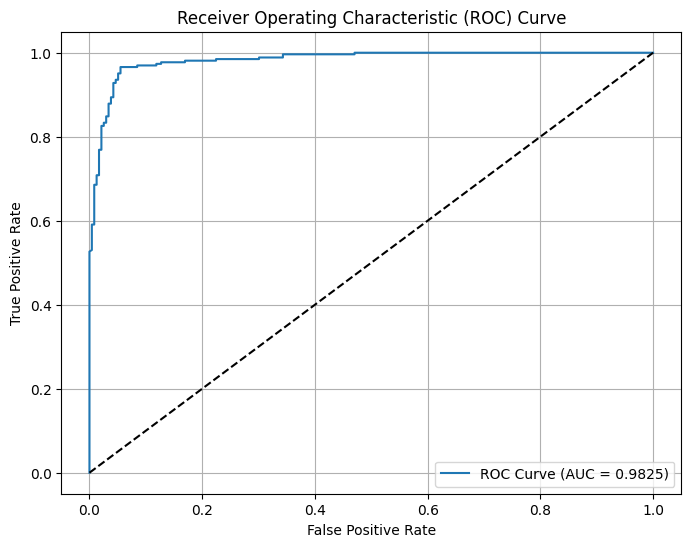

In [39]:
evaluate_model(clf, X_test, y_test)

Overfitting Observed in the Model

From the evaluation results, the model achieves perfect precision on the training set (1.0000) but drops to 0.9275 on the test set. This indicates the model is overfitting — it is learning too much, including noise and outliers from the training data, and hence struggles to generalize well on unseen data.

To handle overfitting, we will apply the following techniques:

1. Cross-validation:
Use stratified k-fold cross-validation to ensure the model’s performance is consistent and robust across different subsets of data, reducing the risk of fitting to noise in one particular split.

2. Regularization:
Incorporate regularization parameters (like gamma, lambda, alpha in XGBoost) to penalize overly complex models and prevent the model from fitting noise and outliers.

#### Hyperparameter Tuning

In [40]:
param_grid = {
    'n_estimators': [10, 25, 30],
    'max_depth': [2],
    'learning_rate': [0.05, 0.07, 0.08],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0.1,0.3,1,3,5],  
    'reg_lambda': [0.1,0.3,1,3,5],
    'tree_method': ['auto', 'hist', 'approx'] 
}

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='precision',
    cv=strat_kfold,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 2700 candidates, totalling 13500 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.08, 'max_depth': 2, 'n_estimators': 30, 'reg_alpha': 0.3, 'reg_lambda': 0.3, 'subsample': 0.8, 'tree_method': 'approx'}


#### Model Evaluation(Tuned Model)

In [41]:
evaluate_model(best_model, X_train,y_train ,plot_roc=False)

Accuracy: 90.25%
Precision: 0.8959
Recall: 0.9471
F1 Score: 0.9208
AUC: 0.9623
Confusion Matrix:
[[403  79]
 [ 38 680]]


Accuracy: 89.80%
Precision: 0.8515
Recall: 0.9773
F1 Score: 0.9101
AUC: 0.9766
Confusion Matrix:
[[191  45]
 [  6 258]]


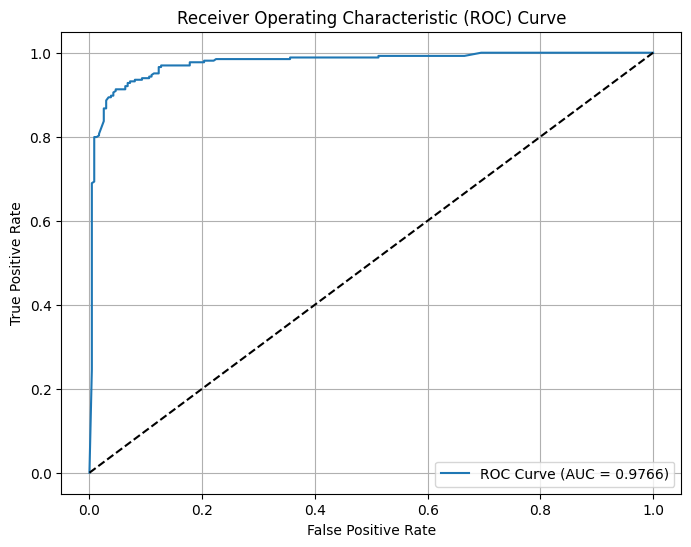

In [42]:
evaluate_model(best_model, X_test, y_test)

Using hyperparameter tuning, cross-validation, and regularization, the model achieved a training precision of 0.8947 and a testing precision of 0.8515. Despite this, I decided to also try a basic model—Naive Bayes—to compare results.

Why Naive Bayes?
Naive Bayes is a simple yet effective algorithm, especially well-suited for text classification tasks like spam detection. Its assumption of feature independence works surprisingly well in practice, making it a preferred baseline for spam classifiers.

### Naive Bayes

#### Model Training

In [43]:
nb_clf = MultinomialNB()
nb_clf.fit(X , y)

MultinomialNB()

#### Model Evaluation

In [44]:
evaluate_model(nb_clf, X,y ,plot_roc=False)

Accuracy: 82.13%
Precision: 0.8199
Recall: 0.8986
F1 Score: 0.8574
AUC: 0.8984
Confusion Matrix:
[[426 177]
 [ 91 806]]


Accuracy: 86.40%
Precision: 0.8182
Recall: 0.9545
F1 Score: 0.8811
AUC: 0.9622
Confusion Matrix:
[[180  56]
 [ 12 252]]


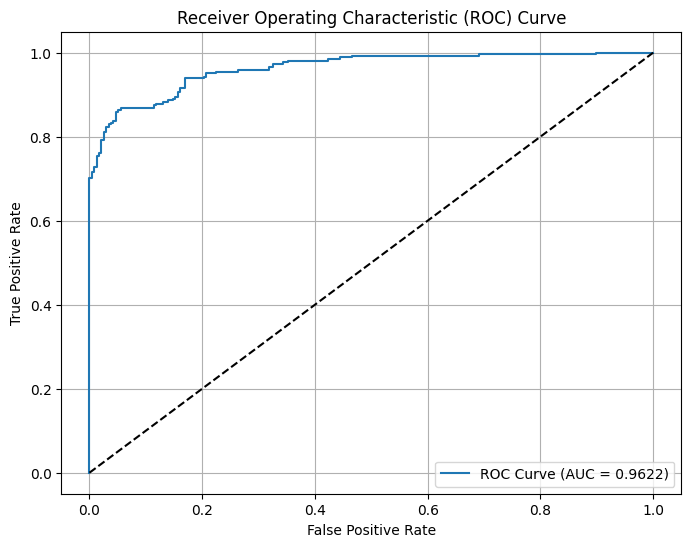

In [45]:
evaluate_model(nb_clf, X_test, y_test)

Based on the training and testing metrics, it is clear that the model is well balanced and does not suffer from overfitting or underfitting. To further improve the performance, we will proceed with hyperparameter tuning.

#### Hyperparameter Tuning

In [46]:
nb_clf = MultinomialNB()

param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1, 5],
    'fit_prior': [True, False]
}

precision_scorer = make_scorer(precision_score)

strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=nb_clf,
    param_grid=param_grid,
    scoring=precision_scorer,
    cv=strat_kfold,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)
print("Best Precision Score:", grid_search.best_score_)

best_nb_clf = grid_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'alpha': 5, 'fit_prior': False}
Best Precision Score: 0.8817857411405798


#### Model Evaluation

Accuracy: 89.00%
Precision: 0.9130
Recall: 0.8750
F1 Score: 0.8936
AUC: 0.9632
Confusion Matrix:
[[214  22]
 [ 33 231]]


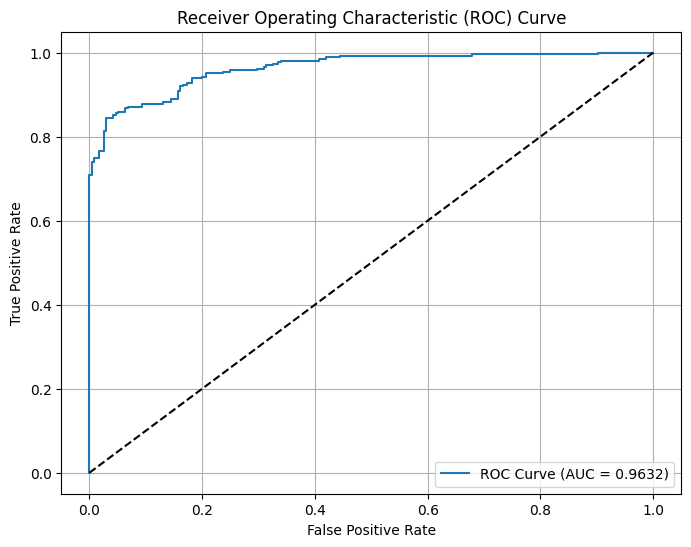

In [47]:
evaluate_model(best_nb_clf, X_test, y_test)

From the above metrics, the model's precision improved significantly from 0.8182 to 0.9243. This indicates a strong enhancement in performance, and we will proceed with this model for further steps. The AUC is 0.963 which is very good.

## Interpretability 

### Model Interpretability

In [48]:
X_train_df = pd.DataFrame(X, columns=train_data.drop("label", axis=1).columns)
explainer = shap.Explainer(best_nb_clf.predict_proba, X_train_df)
shap_values = explainer(X_train_df)

/Users/ganeshmanepalli/Desktop/Mani/depop/denv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MultinomialNB was fitted without feature names
  warnings.warn(
/Users/ganeshmanepalli/Desktop/Mani/depop/denv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MultinomialNB was fitted without feature names
  warnings.warn(
/Users/ganeshmanepalli/Desktop/Mani/depop/denv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MultinomialNB was fitted without feature names
  warnings.warn(
/Users/ganeshmanepalli/Desktop/Mani/depop/denv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MultinomialNB was fitted without feature names
  warnings.warn(
/Users/ganeshmanepalli/Desktop/Mani/depop/denv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Mult

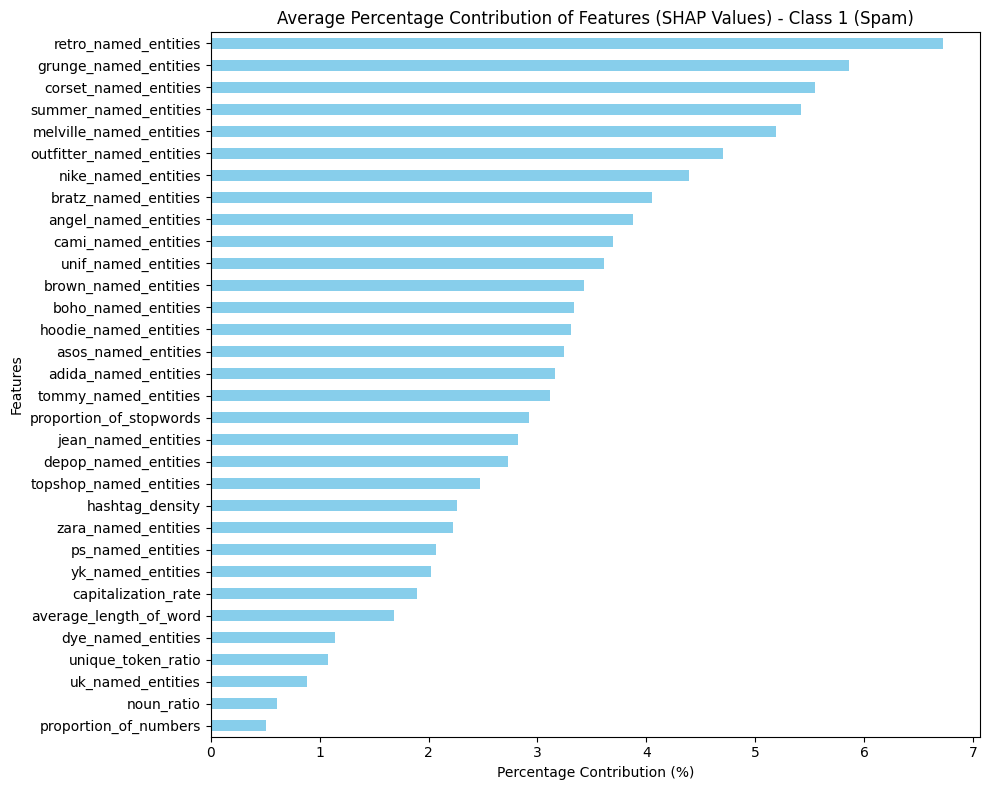

In [54]:
shap_values_class1 = shap_values[:, :, 1] 

shap_abs = pd.DataFrame(np.abs(shap_values_class1.values), columns=X_train_df.columns)
shap_percentage = shap_abs.div(shap_abs.sum(axis=1), axis=0) * 100
avg_shap_percentage = shap_percentage.mean().sort_values(ascending=True)

plt.figure(figsize=(10, 8))
avg_shap_percentage.plot(kind='barh', color='skyblue')  
plt.title('Average Percentage Contribution of Features (SHAP Values) - Class 1 (Spam)')
plt.xlabel('Percentage Contribution (%)')
plt.ylabel('Features')
plt.tight_layout()
plt.show()



To understand which features most influenced the Naive Bayes model’s predictions for spam classification, we used SHAP (SHapley Additive exPlanations). Since MultinomialNB is not directly supported by SHAP’s model-specific explainers, we used the general shap.Explainer.

We computed the average percentage contribution of each feature based on the absolute SHAP values for class 1 (spam), and visualized the top contributors.

Key Observations:
- Top contributing features for spam predictions include brand-related named entities like retro_named_entities, grunge_named_entities, and corpse_named_entities.

- These suggest that certain brand or style keywords are highly indicative of spam.

- Features like proportion_of_stopwords, capitalization_rate, and average_length_of_word also contributed moderately, reflecting stylistic cues.

- Linguistic and metadata-based features such as unique_token_ratio, noun_ratio, and proportion_of_numbers had lower relative impact on spam classification.

This SHAP analysis helps validate that the Naive Bayes model is making decisions based on semantically relevant patterns, especially around branded or stylized named entities.

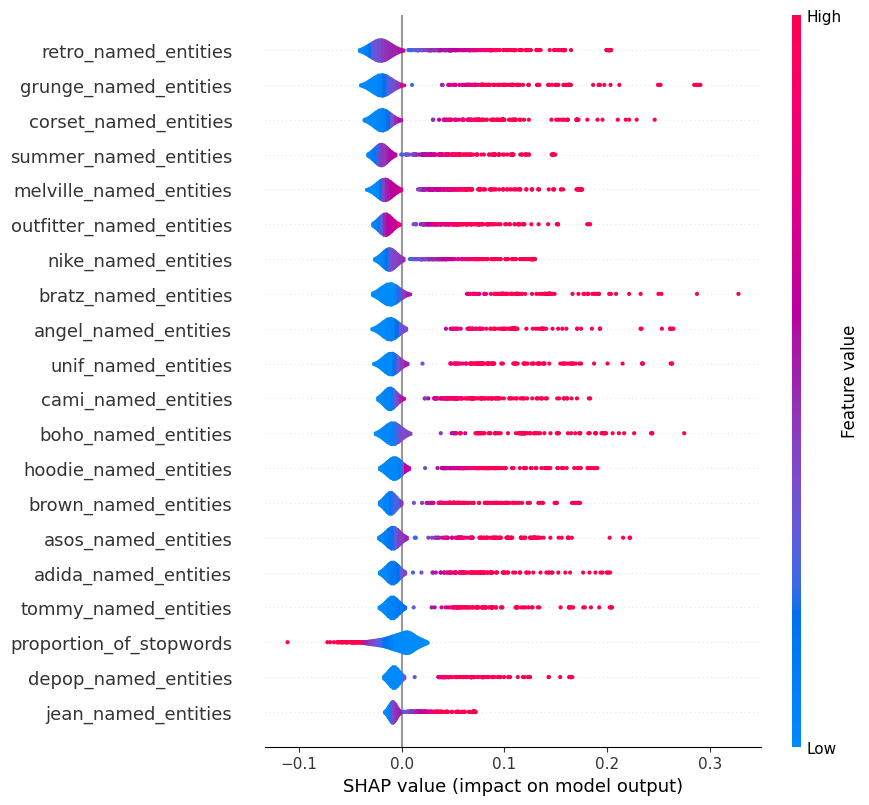

In [52]:
# Plot violin plot for Class 1 (Spam)
shap.plots.violin(shap_values[:, :, 1], feature_names=X_train_df.columns)

This bar plot shows how fashion-related named entities contribute to the model’s predictions using SHAP values.

Key Insights:

* **Strong Positive Influence:**
  Terms like `retro_named_entities`, `grunge_named_entities`, `summer_named_entities`, and brands like `nike`, `adida`, and `tommy` increase the likelihood of spam predictions.

* **Slight Negative/Neutral Impact:**
  Generic features like `proportion_of_stopwords` and terms such as `boho`, `hoodie`, and `jean` reduce model confidence slightly.

Summary:

- The model relies heavily on **brand/style terms** to detect patterns.
- **Stopwords and generic terms** contribute little or negatively.
- Useful for interpreting model behavior in **fashion NLP tasks**.
- Have to reconsider on feature engineering(new features)


## Documentation

### Key Red Flags in Initial Implementation

1. **Test Data Contamination**  
   Test data was unintentionally exposed during vectorizer fitting, leading to data leakage and inflated evaluation metrics.

2. **No Exploratory Data Analysis**  
   Skipped essential EDA steps such as class distribution checks, feature-value inspection, and correlation analysis—critical for shaping feature strategy.

3. **Inappropriate Evaluation Metric**  
   Relied on accuracy despite class imbalance and the business-critical need to minimize false positives. Also omitted ROC AUC evaluation.

4. **Underpowered Model Configuration**  
   Used the xgboost model leading to the overfitting.

6. **Poor Code Practices**  
   Code lacked modular structure and inline comments, making it difficult to read, debug, or extend.


### Summary of Improvements on Initial Model Pipeline

1. **Exploratory Data Analysis (EDA)**  
   - Conducted thorough EDA to assess data distributions, identify missing values, and analyze class imbalance.  
   - Flagged key features such as `image_url`, `yes_count`, and `no_count`—especially the latter two due to strong correlation with the target variable.

2. **Proper Data Splitting & Data Leakage Prevention**  
   - Cleanly separated train and test datasets.  
   - Corrected the vectorization process by fitting TF-IDF only on training data and transforming the test data separately.  
   - Eliminated any test data exposure during model training.

3. **Feature Engineering**  
   Addressed high dimensionality (1003 features vs. 1500 samples) and introduced new, domain-relevant features:
   - `noun_ratio`: Detects noun-heavy branded text.
   - `hashtag_density`: Indicates promotional intent or virality.
   - `unique_token_ratio`: Penalizes repeated/low-diversity text.
   - `capitalization_rate`: Flags text with excessive emphasis or spammy tone.

4. **Evaluation Metrics & Visualization**  
   - Switched to **precision** as the main evaluation metric due to the business need to reduce false positives.  
   - Complemented with confusion matrix, ROC curve, and class-wise breakdowns for richer performance insight.

5. **Model Interpretation**  
   - Employed **SHAP** for both global interpretation.  
   - Provided transparency into how custom-engineered features influence predictions.

6. **Model Changing &Tuning & Efficiency**  
   - XGBoost prone to overfitting due to complex nature
   - Applied **Grid Search with Stratified Cross-Validation** for hyperparameter optimization.  
   - Increased model complexity appropriately (e.g., more estimators), reducing underfitting and improving generalization.


### Further Improvements

1. **Pipeline Structure**:
   The current implementation does not use a formal pipeline (e.g., `Pipeline` or `ColumnTransformer`). Refactoring the code into modular pipelines or custom classes would improve readability, reusability, and deployment readiness.

2. **Model Interpretability**:
   Due to time constraints, limited attention was given to model interpretation. In future iterations, I plan to perform a deeper analysis using SHAP or other interpretability tools to better understand feature influence and make better feature engineering based on feature influence.

3. **Peer Review & Feedback**:
   A peer review would be valuable to validate the approach, identify potential issues, and gain suggestions for optimization or new directions.

4. **Additional Features**:

   * **`image_url` field**: A potential enhancement is to extract captions from image URLs using LLMs (e.g., GPT-4 or BLIP) and incorporate those textual descriptions as features.
   * **`count_yes`, `count_no` fields**: These fields will be explored further after consulting with peers or reviewing the dataset documentation.

